In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys, glob
from datetime import datetime, date
import pyodbc
from urllib.parse import quote_plus
from sqlalchemy import create_engine, event
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import arviz as az
import matplotlib.dates as mdates
import pymc as pm
import xarray as xr

from scipy.stats import norm

c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
def pull_DB_data(DBconfigfilepath, max_date):
    
    '''
    configfile : dot env file with database server info 
    max_date : date from which you need to pull the  data
    
    '''
    load_dotenv(DBconfigfilepath)
    server1 = os.environ.get("server")
    database1 = os.environ.get("database")
    username1 = os.environ.get("user")
    password1 = os.environ.get("password")

    driver1= '{ODBC Driver 17 for SQL Server}'
    conn1 = pyodbc.connect('DRIVER=' + driver1 + ';SERVER=' + server1 + ';PORT=1433;DATABASE=' + database1 +';UID=' + username1 + ';PWD=' + password1)
    quoted1 = quote_plus('DRIVER=' + driver1 + ';SERVER=' + server1 + ';PORT=1433;DATABASE=' + database1 +';UID=' + username1 + ';PWD=' + password1)
    engine=create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted1), fast_executemany=True)

    Division_required = ('EDG Managed - Surface Devices', 'EDG Managed - Surface Accessories', 'EDG Managed - Office License and HP')

    ### Introduced the MISX  in some stores
        
    MISX_stores = (59049, 57616, 315925, 5426789, 16804397, 516542)
    tables = ['FACT_MS_Sales_FY22', 'FACT_MS_Sales_FY23']

    df = pd.DataFrame()

    for table in tables:
        sqlquery =f'''SELECT * FROM {table} WHERE Reseller_Country = 'Germany' AND Super_Division IN {Division_required} AND OrgID IN {MISX_stores}'''
        data = pd.read_sql_query(sqlquery, con=engine)
        df = pd.concat([df, data]).reset_index(drop=True)

    df.drop(['Store',  'Fiscal_Year', 'Fiscal_Month','Reseller_City', 'Reseller_Country', 'Product_Division','Business_Unit'], axis=1, inplace=True)
    df.rename(columns={'OrgID' : 'Org_ID',
                    'Sales_Quantity' : 'Rslr Sales Quantity',
                    'Sell_through' : 'Rslr Sales Amount'}, inplace=True)

    #df['sellprice'] = df['Rslr Sales Amount']/df['Rslr Sales Quantity']
    df['Sales_Date'] = pd.to_datetime(df['Sales_Date'])
    df['Org_ID'] = df['Org_ID'].astype(str)
    df = df.loc[df['Rslr Sales Quantity'] >= 0].reset_index(drop=True)
    df = df.loc[df['Sales_Date'] <= max_date].reset_index(drop=True)
    
    query =f'''SELECT * FROM DIM_Outlets_FY22 WHERE Country = 'Deutschland' AND MISX_Pilot = 1 '''
    df_dim = pd.read_sql_query(query, con=engine)
    df_dim = df_dim[['Outlet_ID', 'Store', 'Org_ID','City', 'Country', 'TheState', 'MISX_Start']]
    df = pd.merge(df, df_dim, on='Org_ID')
    return df, df_dim


def PADDING_DATA(data):
    continuous_data = pd.DataFrame()
    stores = data['Outlet_ID'].unique()
    products= data['Super_Division'].unique()
    least_date = data['Sales_Date'].min()
    latest_date = data['Sales_Date'].max()
    store_names = dict(zip(data['Outlet_ID'], data['Store']))
    for store in stores:
        store_data = data.loc[data['Outlet_ID'] == store].reset_index(drop=True)
        sku_all = store_data['Super_Division'].unique()
        for sku in products:
            sku_data = store_data.loc[store_data['Super_Division']==sku].reset_index(drop=True)
            df = (sku_data.set_index('Sales_Date').reindex(pd.date_range(least_date, latest_date, freq='D')) .rename_axis(['Sales_Date']).fillna(0).reset_index())
            df['Super_Division'] = sku
            df['Outlet_ID'] = store
            df['Store'] = df['Outlet_ID'].map(store_names)
            continuous_data = pd.concat([continuous_data, df]).reset_index(drop=True)
        
    return continuous_data

In [4]:
max_date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
data, df_dim = pull_DB_data('dbconfig.env', max_date)

In [5]:
df1 = pd.read_excel('Input_data/Nova Stock FY21 H1.xlsx')
df2 = pd.read_excel('Input_data/Nova Stock FY21 H2.xlsx')

df = pd.concat([df1, df2]).reset_index(drop=True)
df = df.loc[df['Rslr Sales Quantity'] >=0].reset_index(drop=True)
df['Reseller Organization ID'] = df['Reseller Organization ID'].astype(str)
df['Sales Date'] = pd.to_datetime(df['Sales Date'])

df = df.loc[df['Reseller Organization ID'].isin(['59049', '57616', '315925', '5426789', '16804397', '516542'])].reset_index(drop=True)
df = df.loc[df['Super Division'].isin(['EDG Managed - Surface Devices', 'EDG Managed - Surface Accessories', 'EDG Managed - Office License and HP'])].reset_index(drop=True)

df.rename(columns= {'Part Number' : 'SKU',
                    'Reseller Organization ID' : 'Org_ID',
                    'Super Division' : 'Super_Division', 
                    'Sales Date' : 'Sales_Date'}, inplace=True)

df = df[['SKU', 'Org_ID', 'Super_Division', 'Rslr Sales Amount','Rslr Sales Quantity', 'Sales_Date']]
df = pd.merge(df, df_dim, on='Org_ID')

In [6]:
data = pd.concat([df, data]).reset_index(drop=True)
data = data.groupby(['Sales_Date', 'Outlet_ID', 'Store', 'Super_Division']).sum().reset_index()

In [7]:
def PADDING_DATA(data):
    continuous_data = pd.DataFrame()
    stores = data['Outlet_ID'].unique()
    products= data['Super_Division'].unique()
    least_date = data['Sales_Date'].min()
    latest_date = data['Sales_Date'].max()
    store_names = dict(zip(data['Outlet_ID'], data['Store']))
    for store in stores:
        store_data = data.loc[data['Outlet_ID'] == store].reset_index(drop=True)
        sku_all = store_data['Super_Division'].unique()
        for sku in products:
            sku_data = store_data.loc[store_data['Super_Division']==sku].reset_index(drop=True)
            df = (sku_data.set_index('Sales_Date').reindex(pd.date_range(least_date, latest_date, freq='D')) .rename_axis(['Sales_Date']).fillna(0).reset_index())
            df['Super_Division'] = sku
            df['Outlet_ID'] = store
            df['Store'] = df['Outlet_ID'].map(store_names)
            continuous_data = pd.concat([continuous_data, df]).reset_index(drop=True)
        
    return continuous_data

In [8]:
data = PADDING_DATA(data)
data = data.groupby(['Sales_Date', 'Outlet_ID', 'Store']).sum().reset_index()

In [9]:
data_pd = pd.read_excel('Input_data/Einsatzplanung_01.06.2022___23.06.2023.xlsx')
data_pd['Datum'] = pd.to_datetime(data_pd['Datum'])
data_pd = data_pd.loc[data_pd['Store ID'].isin(['M001','M023','M074', 'M088','M237','M299'])].reset_index(drop=True)
data_pd = data_pd.loc[~data_pd['Status'].isin(['Ausführung', 'gebucht'])].reset_index(drop=True)
data_pd = data_pd[['Datum', 'Store ID', 'Status']]
data_pd.rename(columns={'Datum' : 'Sales_Date',
                        'Store ID' :'Outlet_ID'}, inplace=True)

C:\Users\raviteja.kurva\AppData\Roaming\Python\Python38\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17.06.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\raviteja.kurva\AppData\Roaming\Python\Python38\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '23.06.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\raviteja.kurva\AppData\Roaming\Python\Python38\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '20.06.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\raviteja.kurva\AppData\Roaming\Python\Python38\site-packages\pandas\co

In [10]:
data = pd.merge(data, data_pd, how="left", on=['Outlet_ID', 'Sales_Date'])
data['Status'] = data['Status'].fillna(0)
data['Status'] = np.where(data['Status']!= 0, 1, 0)
data['MISX'] = np.where(data['Sales_Date'] >= '2022-07-01', 1, 0)

In [202]:
storedata = data.loc[data['Outlet_ID'] == 'M001'].reset_index(drop=True)
storedata['month'] = storedata['Sales_Date'].dt.month  # Extract month from date as a new column
storedata['day_of_week'] = storedata['Sales_Date'].dt.dayofweek  # Extract day of the week from date as a new column
storedata['year'] = storedata['Sales_Date'].dt.year
storedata['event'] = np.where((storedata['Sales_Date'].dt.month == 11) & (storedata['Sales_Date'].dt.day >= 24), 1, 0)

storedata.rename(columns={'Rslr Sales Amount' : 'Rslr_Sales_Amount',
                     'Rslr Sales Quantity' : 'Rslr_Sales_Quantity'}, inplace=True)

In [117]:
storedata['Rslr_Sales_Amount'] = storedata['Rslr_Sales_Amount']/storedata['Rslr_Sales_Amount'].mean()

In [18]:
storedata.columns

Index(['Sales_Date', 'Outlet_ID', 'Store', 'Rslr_Sales_Amount',
       'Rslr_Sales_Quantity', 'Status', 'MISX', 'month', 'day_of_week', 'year',
       'event'],
      dtype='object')

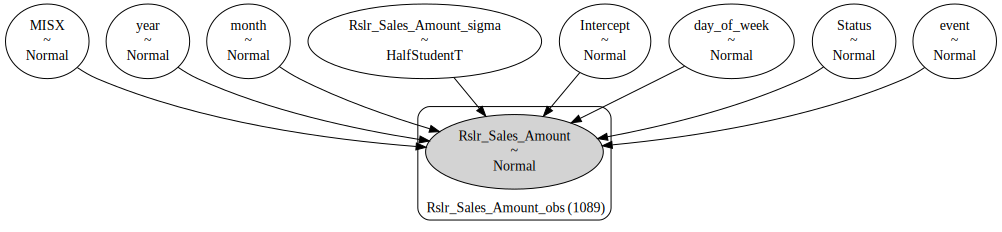

In [21]:
import bambi as bmb
formula = "Rslr_Sales_Amount ~ year + month + day_of_week + MISX + Status + event"
model_bmb = bmb.Model(formula, storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']])
model_bmb.build()
model_bmb.graph(figsize=(12,12))

In [22]:
fitted = model_bmb.fit(random_seed=RANDOM_SEED)
az.summary(fitted)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rslr_Sales_Amount_sigma, Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,949.139,183.335,603.841,1285.370,3.496,2.477,2745.0,2989.0,1.0
year,-0.469,0.091,-0.635,-0.298,0.002,0.001,2745.0,2989.0,1.0
month,0.008,0.017,-0.024,0.041,0.000,0.000,3193.0,3116.0,1.0
day_of_week,-0.086,0.022,-0.131,-0.046,0.000,0.000,6551.0,3156.0,1.0
MISX,0.545,0.162,0.229,0.828,0.003,0.002,2998.0,2727.0,1.0
Status,1.077,0.211,0.664,1.472,0.003,0.002,6452.0,2985.0,1.0
event,2.180,0.331,1.574,2.788,0.004,0.003,6965.0,2845.0,1.0
Rslr_Sales_Amount_sigma,1.448,0.033,1.387,1.508,0.000,0.000,6426.0,2509.0,1.0


c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


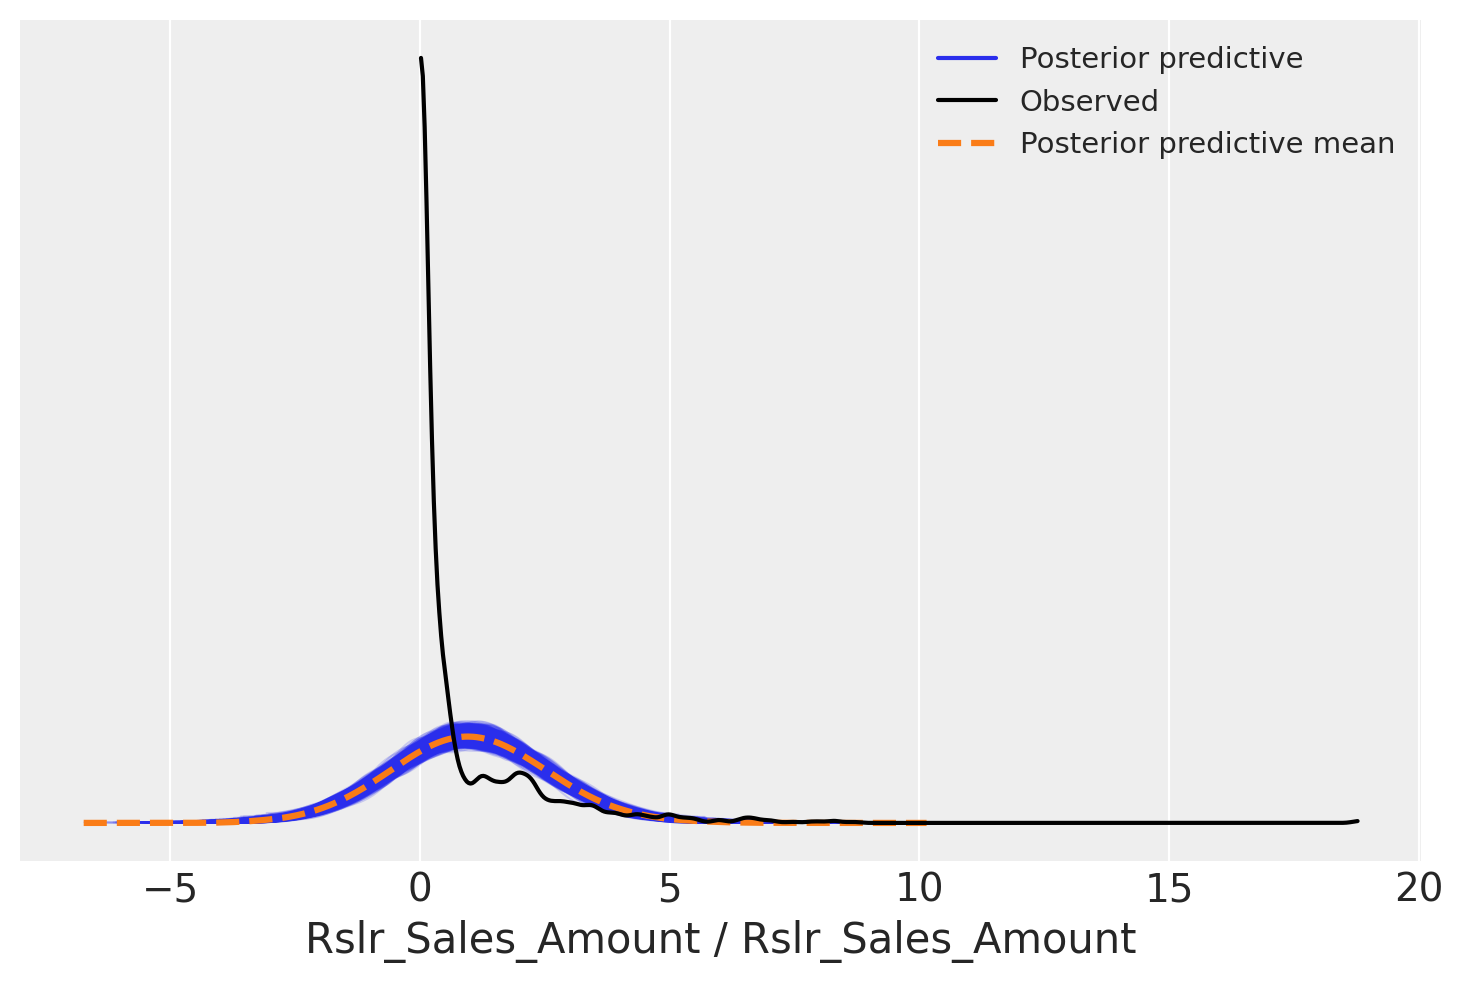

In [24]:
posterior_predictive_ = model_bmb.predict(fitted, kind="pps", data=storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']])
az.plot_ppc(fitted);

#### gamma model 

In [94]:
storedata['Rslr_Sales_Amount'] = np.where(storedata['Rslr_Sales_Amount'] <= 0,  0.001, storedata['Rslr_Sales_Amount'])

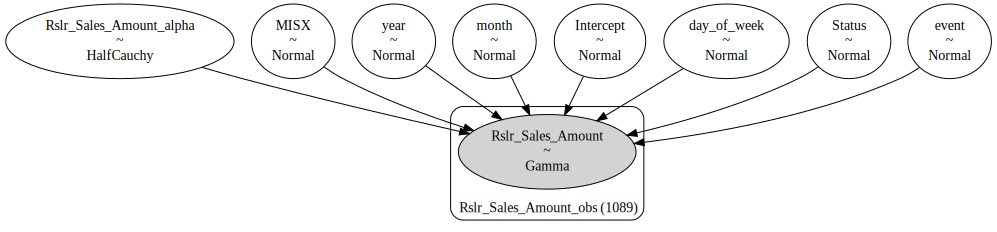

In [119]:
model_bmb_gamma = bmb.Model(formula, storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']], family='gamma', link="log")
model_bmb_gamma.build()
model_bmb_gamma.graph(figsize=(12,12))

In [120]:
fitted_gamma = model_bmb_gamma.fit(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})
az.summary(fitted_gamma)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rslr_Sales_Amount_alpha, Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,901.038,288.981,336.372,1422.149,5.511,3.897,2754.0,2707.0,1.0
year,-0.446,0.143,-0.703,-0.166,0.003,0.002,2754.0,2707.0,1.0
month,0.019,0.028,-0.032,0.071,0.000,0.000,3310.0,2830.0,1.0
day_of_week,-0.132,0.039,-0.209,-0.064,0.000,0.000,7218.0,2608.0,1.0
MISX,0.522,0.256,0.047,0.995,0.005,0.004,2592.0,2869.0,1.0
Status,1.112,0.347,0.416,1.725,0.004,0.003,6953.0,3272.0,1.0
event,1.044,0.531,0.124,2.099,0.008,0.007,4846.0,2409.0,1.0
Rslr_Sales_Amount_alpha,0.200,0.007,0.188,0.213,0.000,0.000,5219.0,2490.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rslr_Sales_Amount_alpha, Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [Rslr_Sales_Amount]


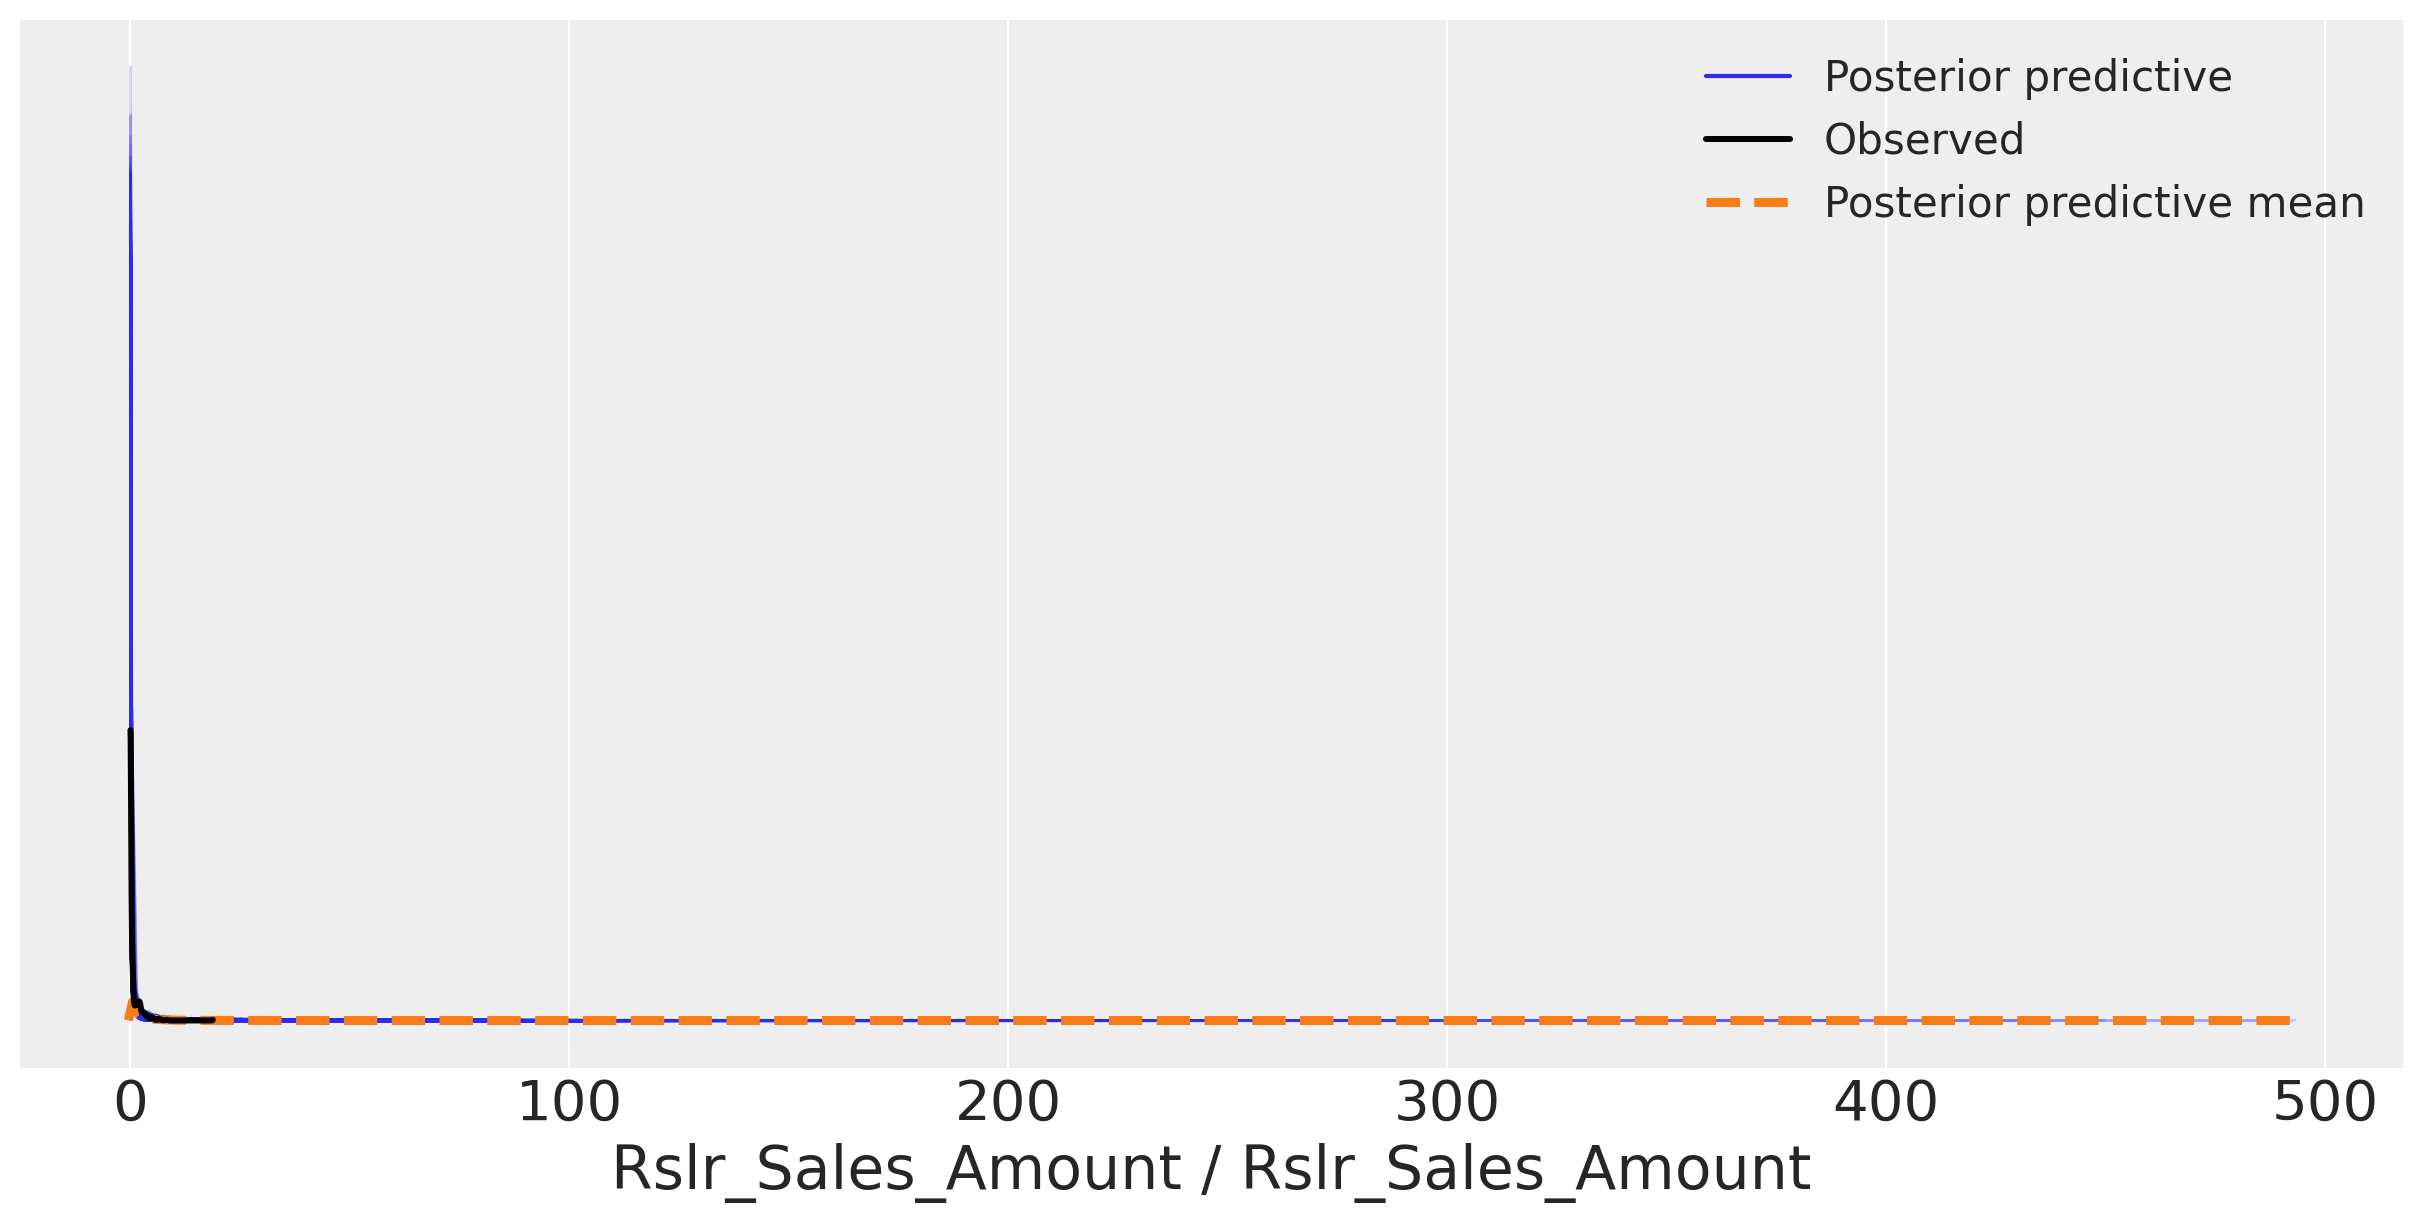

In [122]:
# Fit the model using PyMC3
pymc3_model = model_bmb_gamma.backend.model
with pymc3_model:
    fitted_gamma = pm.sample(draws=1000, tune=1000, init="adapt_diag", random_seed=RANDOM_SEED)

# Extract posterior predictive samples
ppc = pm.sample_posterior_predictive(fitted_gamma, model=pymc3_model)

# Plot posterior predictive distribution
az.plot_ppc(ppc, figsize=(12, 6))
plt.show()



In [134]:
az.summary(fitted_gamma)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.098,0.065,-0.214,0.027,0.001,0.001,7046.0,3503.0,1.0
year,-0.445,0.144,-0.719,-0.172,0.003,0.002,2786.0,2813.0,1.0
month,0.019,0.028,-0.033,0.070,0.000,0.000,3400.0,3084.0,1.0
day_of_week,-0.131,0.038,-0.201,-0.057,0.000,0.000,7741.0,3025.0,1.0
MISX,0.517,0.260,0.021,0.995,0.005,0.004,2903.0,3040.0,1.0
Status,1.115,0.349,0.472,1.749,0.005,0.004,5527.0,2729.0,1.0
event,1.043,0.522,0.029,1.980,0.007,0.006,6081.0,2632.0,1.0
Rslr_Sales_Amount_alpha,0.200,0.007,0.188,0.212,0.000,0.000,6281.0,3039.0,1.0


In [132]:
summary_df = az.summary(fitted_gamma, kind='stats')
print(summary_df)

                          mean     sd  hdi_3%  hdi_97%
Intercept               -0.098  0.065  -0.214    0.027
year                    -0.445  0.144  -0.719   -0.172
month                    0.019  0.028  -0.033    0.070
day_of_week             -0.131  0.038  -0.201   -0.057
MISX                     0.517  0.260   0.021    0.995
Status                   1.115  0.349   0.472    1.749
event                    1.043  0.522   0.029    1.980
Rslr_Sales_Amount_alpha  0.200  0.007   0.188    0.212


#### Second gamma model with tuned



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rslr_Sales_Amount_alpha, Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rslr_Sales_Amount_alpha, Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Sampling: [Rslr_Sales_Amount]


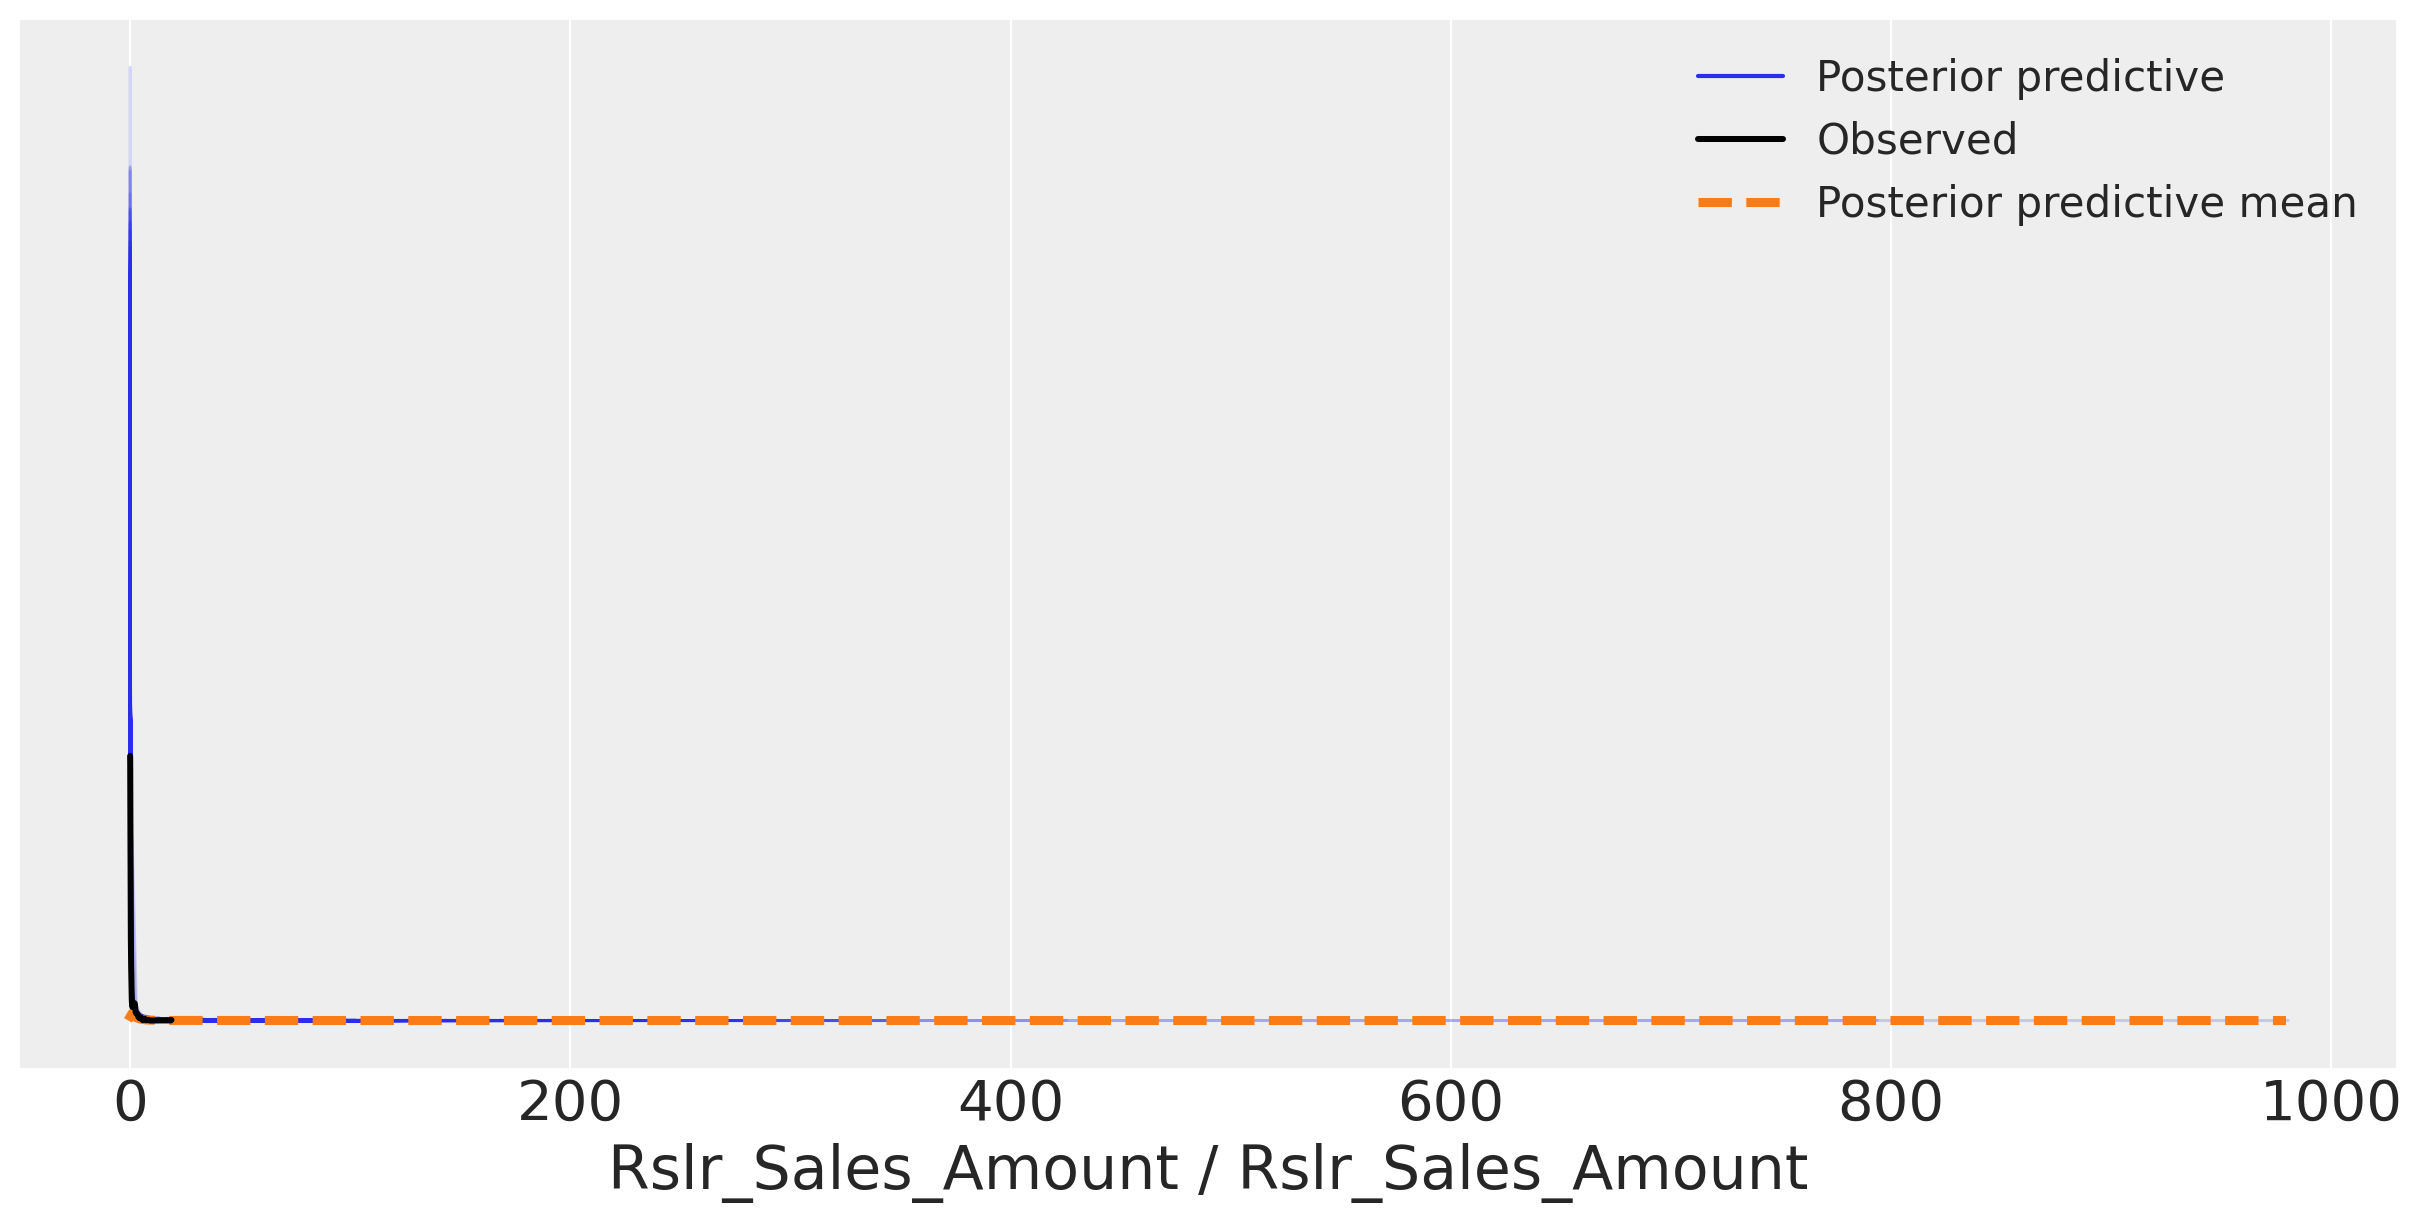

In [138]:
# Create the gamma model with log link function
model_bmb_gamma = bmb.Model(formula, storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year', 'event']], family='gamma', link="log")
model_bmb_gamma.build()
model_bmb_gamma.graph(figsize=(12, 12))

# Fit the model using Bambi and extract posterior samples
fitted_gamma = model_bmb_gamma.fit(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

# Extract the PyMC3 model
pymc3_model = model_bmb_gamma.backend.model

# Fit the model using PyMC3
with pymc3_model:
    fitted_gamma = pm.sample(draws=1000, tune=1000, init="adapt_diag", random_seed=RANDOM_SEED)

# Extract posterior predictive samples
ppc = pm.sample_posterior_predictive(fitted_gamma, model=pymc3_model)

# Plot posterior predictive distribution
az.plot_ppc(ppc, figsize=(12, 6))
plt.show()

In [139]:
az.summary(fitted_gamma)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.098,0.065,-0.214,0.027,0.001,0.001,7046.0,3503.0,1.0
year,-0.445,0.144,-0.719,-0.172,0.003,0.002,2786.0,2813.0,1.0
month,0.019,0.028,-0.033,0.070,0.000,0.000,3400.0,3084.0,1.0
day_of_week,-0.131,0.038,-0.201,-0.057,0.000,0.000,7741.0,3025.0,1.0
MISX,0.517,0.260,0.021,0.995,0.005,0.004,2903.0,3040.0,1.0
Status,1.115,0.349,0.472,1.749,0.005,0.004,5527.0,2729.0,1.0
event,1.043,0.522,0.029,1.980,0.007,0.006,6081.0,2632.0,1.0
Rslr_Sales_Amount_alpha,0.200,0.007,0.188,0.212,0.000,0.000,6281.0,3039.0,1.0


#### second model 

In [133]:
type(summary_df)

pandas.core.frame.DataFrame

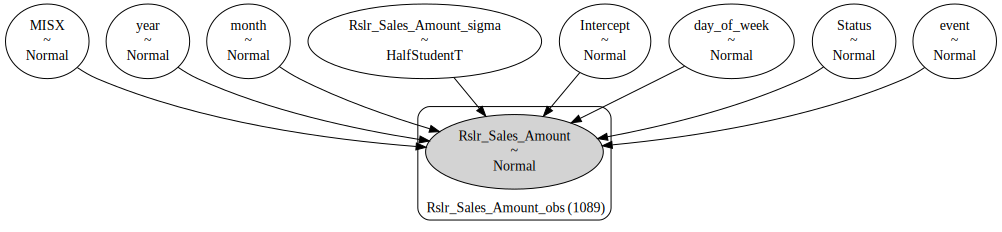

In [25]:
priors_hier = {"Intercept": bmb.Prior("Normal", mu=0, sigma=1), 
               "group": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1))}

model_bmb_hier = bmb.Model(formula, data= storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']], priors=priors_hier)

model_bmb_hier.build()
model_bmb_hier.graph(figsize=(12,12))

In [26]:
fitted_hier = model_bmb_hier.fit(10000, tune=10000, target_accept=.95, random_seed=RANDOM_SEED)
az.summary(fitted_hier)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rslr_Sales_Amount_sigma, Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 314 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,946.975,185.399,602.662,1297.577,1.091,0.777,28871.0,27545.0,1.0
year,-0.468,0.092,-0.641,-0.298,0.001,0.000,28874.0,27605.0,1.0
month,0.008,0.017,-0.024,0.041,0.000,0.000,33122.0,31107.0,1.0
day_of_week,-0.087,0.022,-0.129,-0.046,0.000,0.000,47864.0,28462.0,1.0
MISX,0.544,0.166,0.238,0.865,0.001,0.001,30382.0,27880.0,1.0
Status,1.076,0.215,0.676,1.485,0.001,0.001,47773.0,29335.0,1.0
event,2.184,0.324,1.589,2.807,0.001,0.001,48351.0,28070.0,1.0
Rslr_Sales_Amount_sigma,1.448,0.031,1.391,1.507,0.000,0.000,47426.0,28460.0,1.0


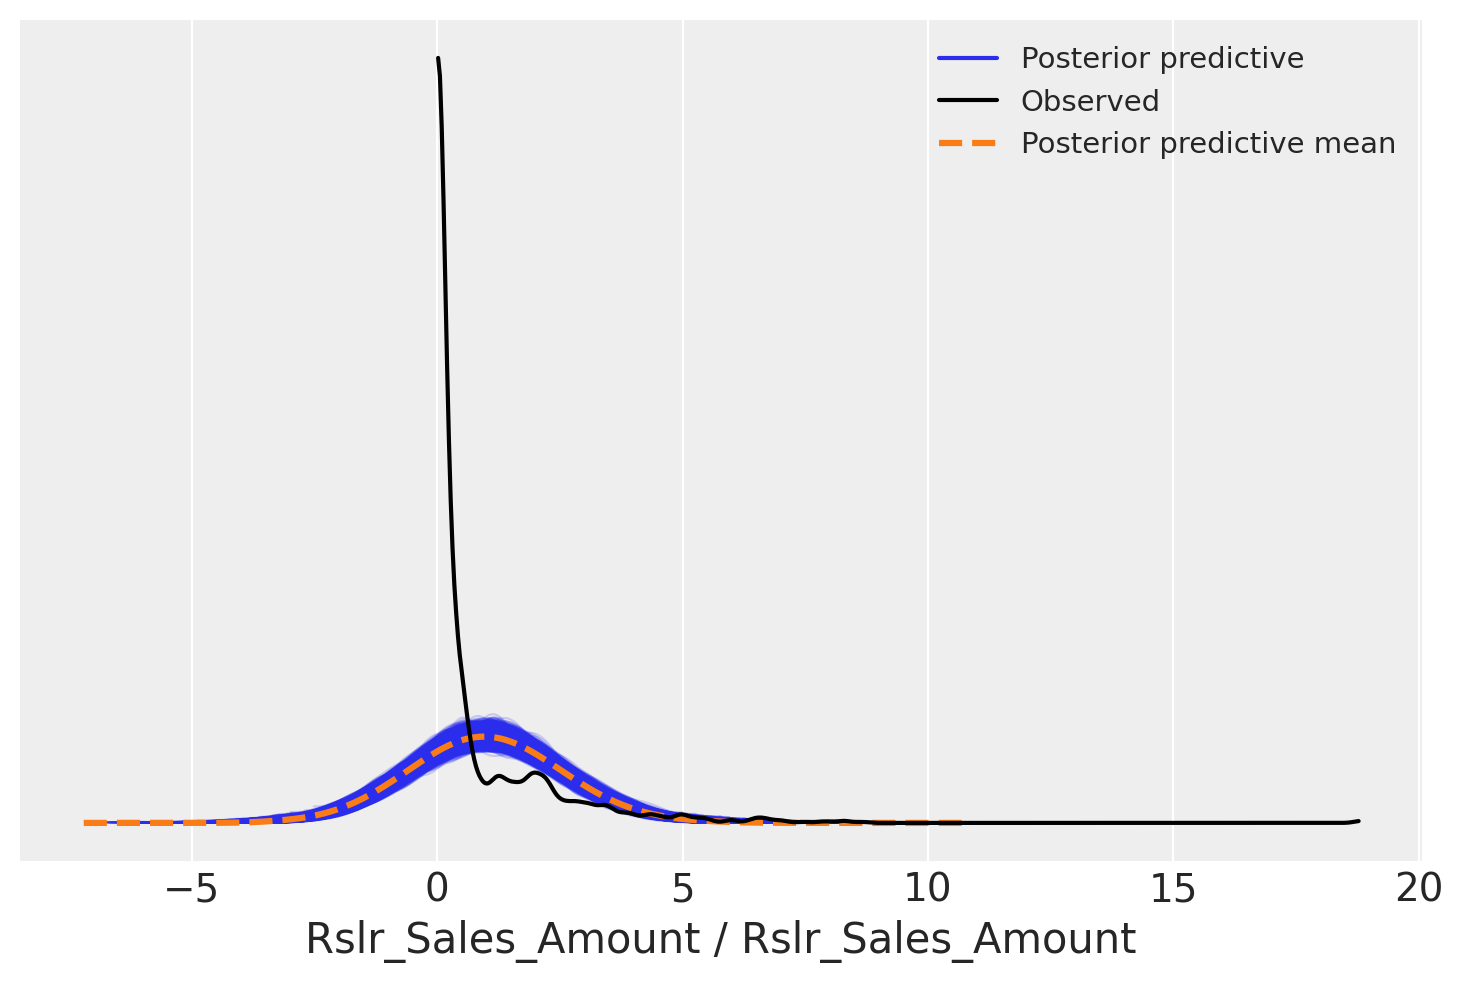

In [27]:
posterior_predictive_hier = model_bmb_hier.predict(fitted_hier, kind="pps")
az.plot_ppc(fitted_hier);

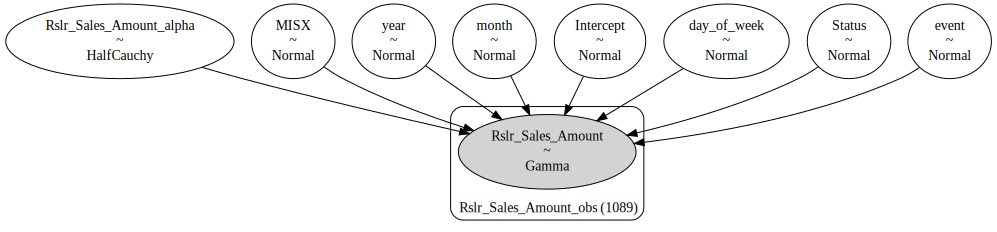

In [251]:
mean_hyperprior1 = bmb.Prior("Normal", mu=0, sigma=10)
prec_hyperprior1 = bmb.Prior("Gamma", alpha=4, beta=1, testval=1.0)

priors_hier_glm1 = {"Intercept": bmb.Prior("Normal", mu=0, sigma=1),
                   "slope": bmb.Prior("StudentT", mu=mean_hyperprior1, lam=prec_hyperprior1, nu=1)}

family1 = "gamma"
family_params = {"alpha": 0.5, "beta": 0.5}

model_bmb_hier_glm1 = bmb.Model(formula, data=storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']], priors=priors_hier_glm1, family=family1)

model_bmb_hier_glm1.build()
model_bmb_hier_glm1.graph(figsize=(12,12))

In [253]:
fitted_hier_glm1 = model_bmb_hier_glm1.fit(1000, tune=1000)
az.summary(fitted_hier_glm1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Rslr_Sales_Amount_alpha_log__': array(0.85479346), 'Intercept': array(0.59124445), 'year': array(0.80845962), 'month': array(0.1206553), 'day_of_week': array(0.87748916), 'MISX': array(0.58140373), 'Status': array(0.25514144), 'event': array(-0.23670837)}

Logp initial evaluation results:
{'Rslr_Sales_Amount_alpha': -1.47, 'Intercept': -1.09, 'year': -1.93, 'month': -0.61, 'day_of_week': -1.39, 'MISX': -2.6, 'Status': -3.4, 'event': -3.82, 'Rslr_Sales_Amount': -inf}
You can call `model.debug()` for more details.

In [ ]:
posterior_predictive_hier_glm_1 = model_bmb_hier_glm1.predict(fitted_hier_glm1, kind="pps", data=storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']])
az.plot_ppc(fitted_hier_glm1);

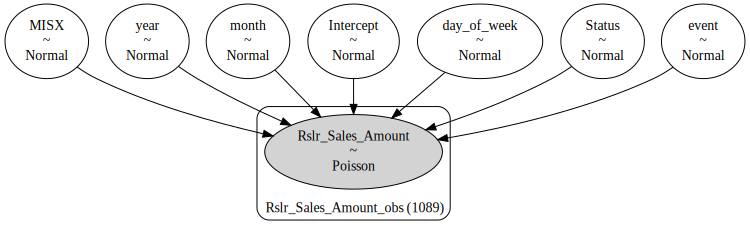

In [28]:
mean_hyperprior = bmb.Prior("Normal", mu=0, sigma=10)
prec_hyperprior = bmb.Prior("Gamma", alpha=1, beta=0.1, testval=1.0)

priors_hier_glm = {"Intercept": bmb.Prior("Normal", mu=0, sigma=1),
                   "slope": bmb.Prior("StudentT", mu=mean_hyperprior, lam=prec_hyperprior, nu=1)}

family = "poisson"

model_bmb_hier_glm = bmb.Model(formula, data=storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']], priors=priors_hier_glm, family=family)

model_bmb_hier_glm.build()
model_bmb_hier_glm.graph(figsize=(12,12))

In [29]:
fitted_hier_glm = model_bmb_hier_glm.fit(5000, tune=1000, target_accept=.95, random_seed=RANDOM_SEED)
az.summary(fitted_hier_glm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year, month, day_of_week, MISX, Status, event]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 126 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1369.561,160.185,1067.764,1673.757,1.482,1.055,11702.0,12188.0,1.0
year,-0.678,0.079,-0.828,-0.529,0.001,0.001,11702.0,12188.0,1.0
month,0.003,0.015,-0.026,0.031,0.000,0.000,14030.0,14086.0,1.0
day_of_week,-0.084,0.018,-0.116,-0.048,0.000,0.000,21465.0,14235.0,1.0
MISX,0.816,0.155,0.527,1.110,0.001,0.001,11984.0,13434.0,1.0
Status,1.045,0.136,0.791,1.303,0.001,0.001,19637.0,13825.0,1.0
event,1.159,0.140,0.898,1.426,0.001,0.001,21153.0,14035.0,1.0


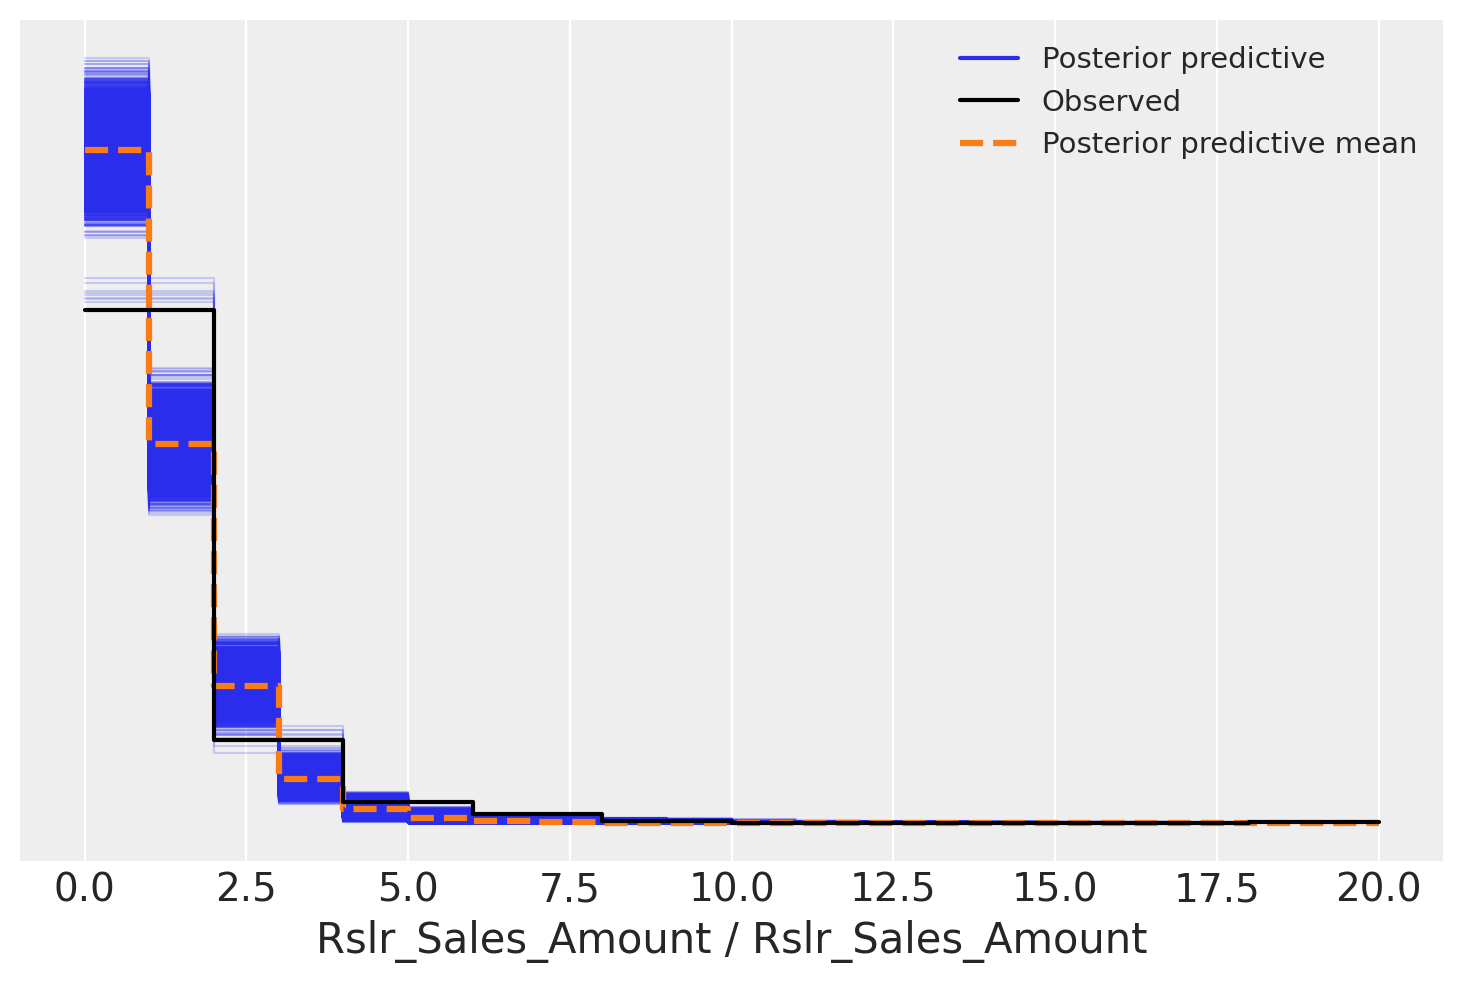

In [30]:

posterior_predictive_hier_glm_ = model_bmb_hier_glm.predict(fitted_hier_glm, kind="pps", data=storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']])
az.plot_ppc(fitted_hier_glm);

In [149]:
storedata = storedata.dropna(subset=['Rslr_Sales_Amount'])

In [152]:
storedata[['Rslr_Sales_Amount', 'Status', 'MISX', 'month', 'day_of_week', 'year','event']].dtypes

Rslr_Sales_Amount    float64
Status                 int32
MISX                   int32
month                  int64
day_of_week            int64
year                   int64
event                  int32
dtype: object

### new model

In [ ]:
az.plot_ppc(fitted_hier_glm);

In [ ]:
storedata['Rslr_Sales_Amount'] = pd.to_numeric(storedata['Rslr_Sales_Amount'], errors='coerce')  # Convert to numeric

# Define the model
with pm.Model() as model:
    # Prior for the impact of offline campaign
    beta_offline = pm.Normal('beta_offline', mu=0, sigma=1)
    
    # Prior for the impact of discounts
    beta_discounts = pm.Normal('beta_discounts', mu=0, sigma=1)
    
    # Priors for the impact of promotion events
    beta_blackweek = pm.Normal('beta_blackweek', mu=0, sigma=1)
   
    
    # Compute the expected sales based on the variables
    expected_sales = (storedata['MISX'].values * beta_offline +
                      storedata['Status'].values * beta_discounts +
                      storedata['event'].values * beta_blackweek )
    
    # Likelihood of observed sales
    sales_observed = pm.Normal('sales_observed', mu=expected_sales, observed=storedata['Rslr_Sales_Amount'].values)
    
    # Run the model
    trace = pm.sample(1000, tune=1000)


    
# Extract the posterior distributions
posterior_offline = trace.posterior['beta_offline'].values
posterior_discounts = trace.posterior['beta_discounts'].values
posterior_blackweek = trace.posterior['beta_blackweek'].values



# Analyze the results
mean_offline = posterior_offline.mean()
mean_discounts = posterior_discounts.mean()
mean_blackweek = posterior_blackweek.mean()


# Print the mean estimates
print("Mean impact of offline campaign:", mean_offline)
print("Mean impact of discounts:", mean_discounts)
print("Mean impact of blackweek promotion:", mean_blackweek)


Sampling: [sales_observed]


c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sales_observed[0],0.00,1.00,-1.88,2.04,0.02,0.01,3962.11,3993.76,1.0
sales_observed[1],-0.00,0.98,-1.78,2.00,0.02,0.01,4113.29,4056.97,1.0
sales_observed[2],0.01,0.99,-1.87,1.97,0.02,0.01,3935.03,3720.64,1.0
sales_observed[3],-0.03,1.00,-1.90,2.01,0.02,0.01,3930.74,3764.00,1.0
sales_observed[4],0.02,0.99,-1.87,1.98,0.02,0.01,3954.81,3813.95,1.0
...,...,...,...,...,...,...,...,...,...
sales_observed[1084],0.78,0.99,-1.10,2.75,0.02,0.01,4018.54,3666.02,1.0
sales_observed[1085],0.77,0.99,-1.12,2.76,0.02,0.01,3885.89,3759.78,1.0
sales_observed[1086],0.78,0.99,-1.17,2.67,0.02,0.01,4053.86,3929.93,1.0
sales_observed[1087],0.79,1.00,-1.10,2.80,0.02,0.01,4145.18,4087.10,1.0


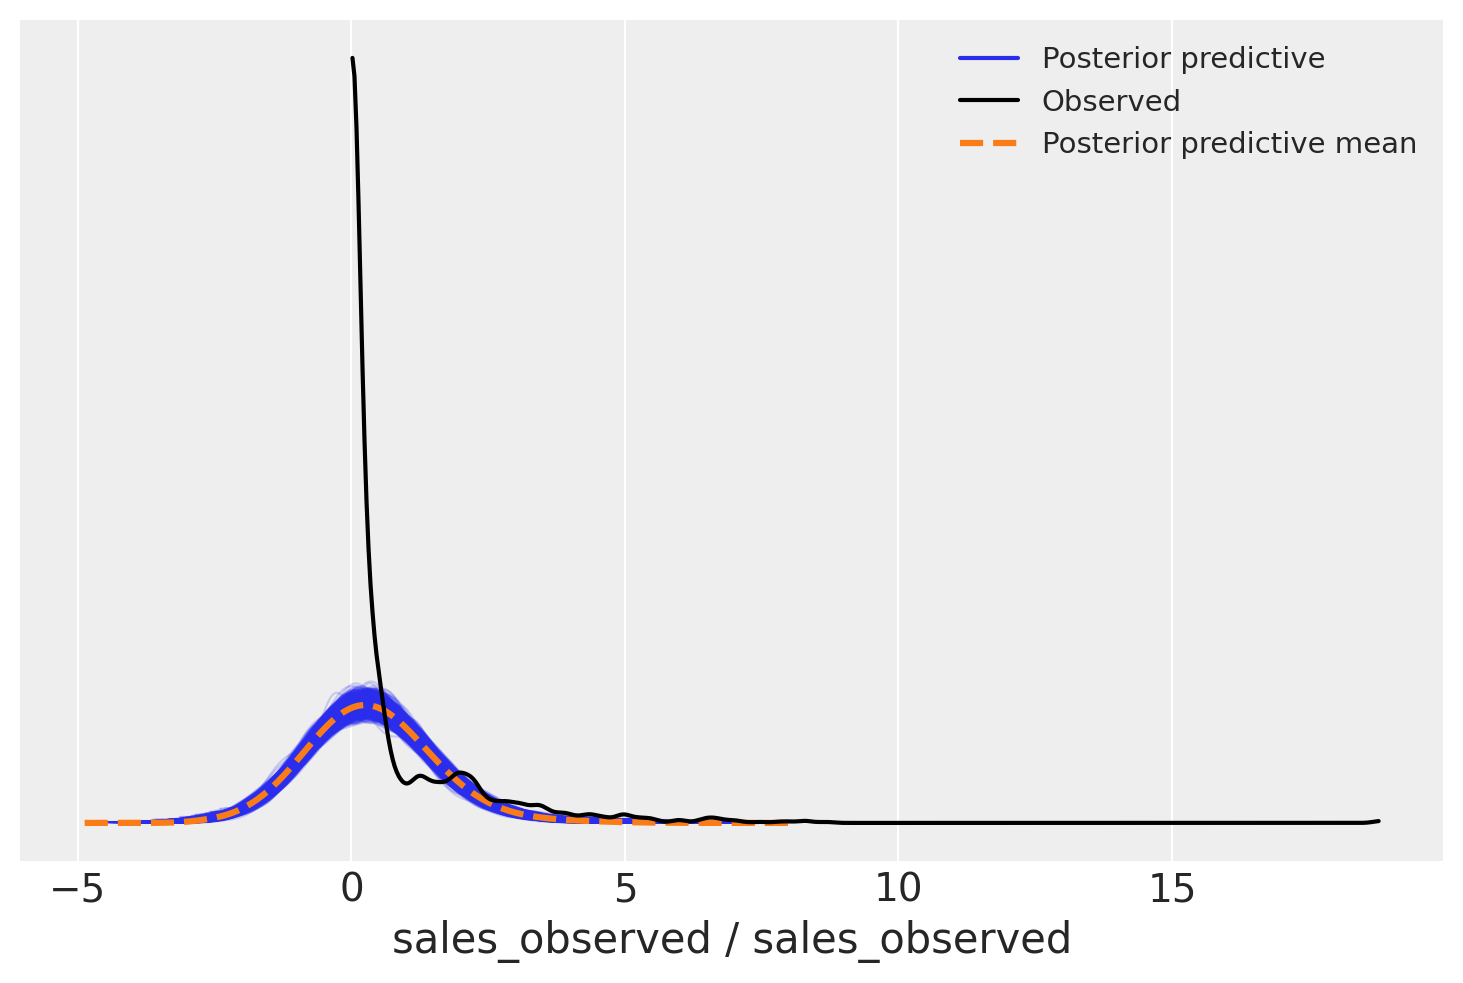

In [165]:
# Perform posterior predictive checks
ppc = pm.sample_posterior_predictive(trace, model=model, var_names=['sales_observed'])

# Compare observed data with posterior predictive samples
observed_data = storedata['Rslr_Sales_Amount'].values
az.plot_ppc(ppc)



In [195]:
# Extract the posterior distributions
posterior_offline = trace.posterior['beta_MISX'].values
posterior_discounts = trace.posterior['beta_Status'].values
posterior_blackweek = trace.posterior['beta_event'].values



# Analyze the results
mean_offline = posterior_offline.mean()
mean_discounts = posterior_discounts.mean()
mean_blackweek = posterior_blackweek.mean()


# Print the mean estimates
print("Mean impact of offline campaign:", mean_offline)
print("Mean impact of discounts:", mean_discounts)
print("Mean impact of blackweek promotion:", mean_blackweek)

Mean impact of offline campaign: 46.59236032055675
Mean impact of discounts: 15.503115583247299
Mean impact of blackweek promotion: 13.693512264091472


Sampling: [sales_observed]


<Axes: xlabel='sales_observed / sales_observed'>

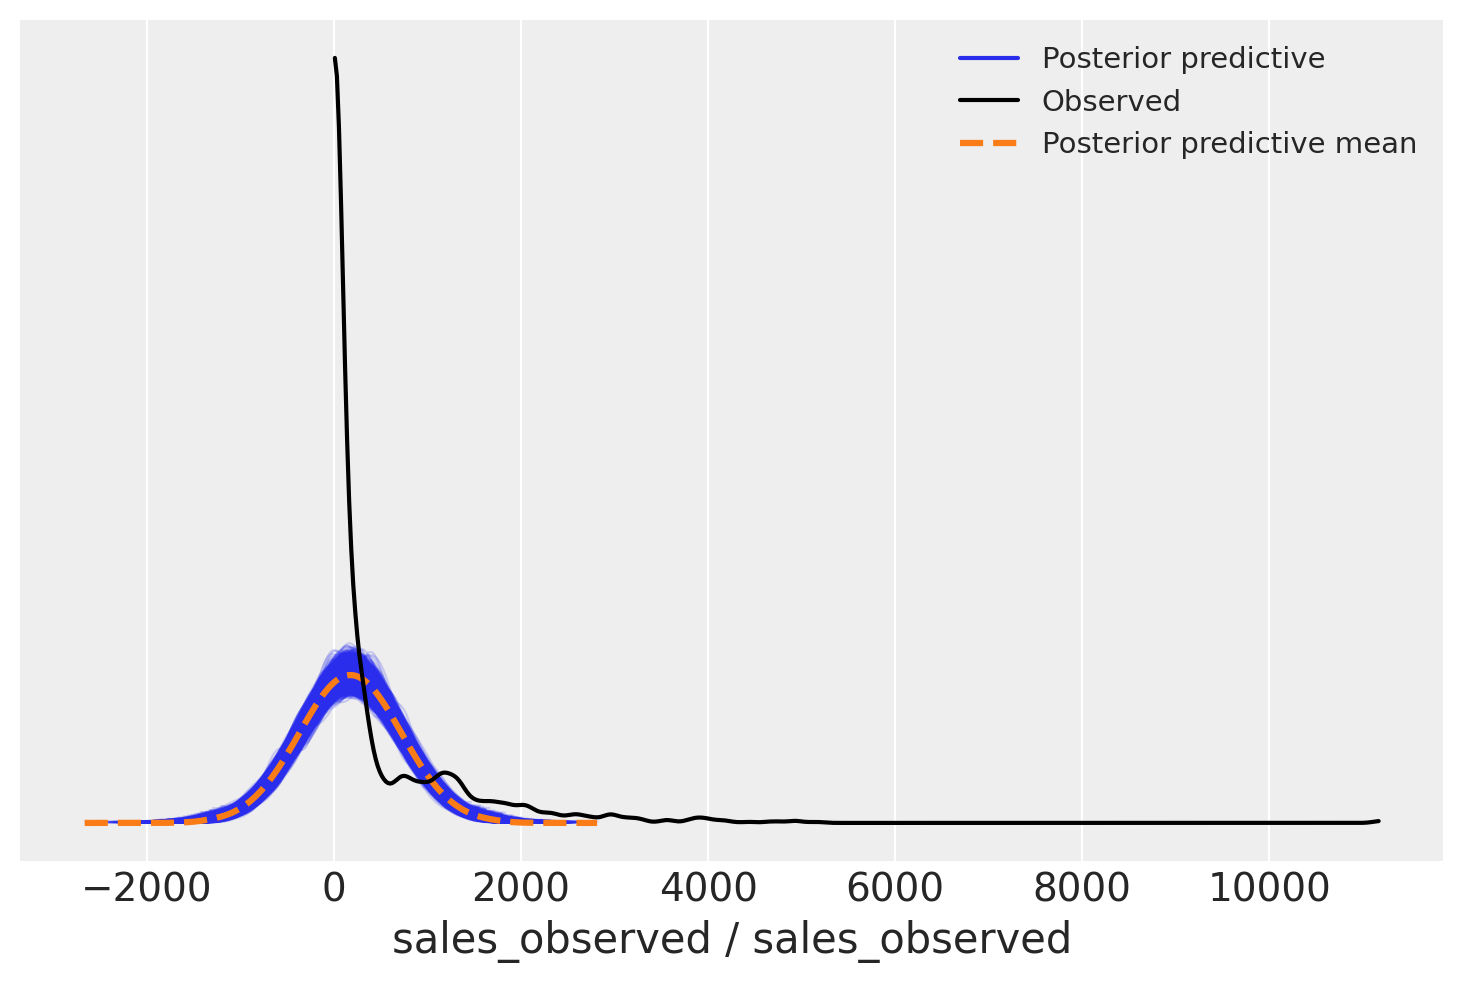

In [196]:
# Perform posterior predictive checks
ppc = pm.sample_posterior_predictive(trace, model=model, var_names=['sales_observed'])

# Compare observed data with posterior predictive samples
observed_data = storedata['Rslr_Sales_Amount'].values
az.plot_ppc(ppc)

In [161]:
trace.posterior['beta_offline'].values

array([[0.65211703, 0.73778685, 0.79774958, ..., 0.74940777, 0.8218485 ,
        0.87457943],
       [0.81856792, 0.8013058 , 0.86667314, ..., 0.80558515, 0.70293055,
        0.8005285 ],
       [0.78583469, 0.80677728, 0.87379046, ..., 0.74275872, 0.78969623,
        0.82141737],
       [0.79047837, 0.82410077, 0.81596674, ..., 0.77017177, 0.85239745,
        0.81721589]])

#### ZeroInflatedBinomial

In [257]:
dffff = pd.read_csv(pm.get_data("deaths_and_temps_england_wales.csv"))

In [258]:
dffff 

,date,temp,deaths,year,month,t,pre
0,2006-01-01,3.8,49124,2006,1,0,True
1,2006-02-01,3.4,42664,2006,2,1,True
2,2006-03-01,3.9,49207,2006,3,2,True
3,2006-04-01,7.4,40645,2006,4,3,True
4,2006-05-01,10.7,42425,2006,5,4,True
...,...,...,...,...,...,...,...
192,2022-01-01,4.7,53158,2022,1,192,False
193,2022-02-01,5.6,45869,2022,2,193,False
194,2022-03-01,6.7,49489,2022,3,194,False
195,2022-04-01,8.1,45919,2022,4,195,False


In [270]:
storedata = storedata.assign(time=np.arange(len(storedata['Sales_Date'].unique())), date=pd.date_range(
    start=pd.to_datetime("2020-07-01"), end=pd.to_datetime("2023-06-24"), freq="D"
))

In [271]:
pre = storedata.loc[storedata['Sales_Date'] < '2022-07-01'].reset_index(drop=True)
post = storedata.loc[storedata['Sales_Date'] >= '2022-07-01'].reset_index(drop=True)

In [275]:
import calendar
import pytensor.tensor as pt
import xarray as xr
month_strings = calendar.month_name[1:]
weekday_string = calendar.day_name[0:]

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)


In [332]:
with pm.Model(coords={"month": month_strings, 'day_of_week' : weekday_string}) as model:

    # observed predictors and outcome
    dayweek = pm.MutableData("day_of_week", pre["day_of_week"].to_numpy(), dims="t")
    month = pm.MutableData("month", pre["month"].to_numpy(), dims="t")
    year = pm.MutableData("year", pre["year"].to_numpy(), dims="t")
    time = pm.MutableData("time", pre["time"].to_numpy(), dims="t")
    misx = pm.MutableData("MISX", pre["MISX"].to_numpy(), dims="t")
    Status = pm.MutableData("Status", pre["Status"].to_numpy(), dims="t")
    event = pm.MutableData("event", pre["event"].to_numpy(), dims="t")
    sales = pm.Poisson("Rslr_Sales_Amount", pre["Rslr_Sales_Amount"].to_numpy(), dims="t")

    # priors
    intercept = pm.Normal("intercept", 800, 1)
    month_mu = ZeroSumNormal("month mu", sigma=100, dims="month")
    weekday_mu = ZeroSumNormal("weekday mu", sigma=100, dims="day_of_week")
    linear_trend = pm.TruncatedNormal("linear trend", 0, 0.05, lower=0)
    misx_coeff = pm.Normal("misx coeff", 0, 100)
    Status_coeff = pm.Normal("Status coeff", 0, 800)
    event_coeff = pm.Normal("event coeff", 0, 1200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) + year + month_mu[month - 1] + weekday_mu[dayweek - 1]+ (misx_coeff* misx) + (Status_coeff* Status) + (event_coeff* event),
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 300)
    # likelihood
    #pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=sales, dims="t")
    #pm.InverseGamma("obs", alpha=3, beta= 0.5, mu=mu, sigma=sigma, observed=sales, dims="t")
    pm.ZeroInflatedPoisson("obs", psi=0.1, mu=mu, observed=sales, dims="t")

In [357]:
# Define the variables
sales = storedata['Rslr_Sales_Amount'].to_numpy()
misx = storedata['MISX'].to_numpy().astype(int)
Status = storedata['Status'].to_numpy().astype(int)
event = storedata['event'].to_numpy().astype(int)

# Define the model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=800)
    linear_trend = pm.TruncatedNormal("linear_trend", mu=0, sigma=0.05, lower=0)
    misx_coeff = pm.Normal("misx_coeff", mu=0, sigma=100)
    Status_coeff = pm.Normal("Status_coeff", mu=0, sigma=800)
    event_coeff = pm.Normal("event_coeff", mu=0, sigma=1200)
    psi = pm.Beta("psi", alpha=1, beta=1)  # Zero-inflation parameter
    n = pm.Gamma("n", alpha=2, beta=0.1)  # Shape parameter of negative binomial

    # Linear model
    mu = (
        intercept
        + linear_trend * storedata['time']
        + misx_coeff * misx
        + Status_coeff * Status
        + event_coeff * event
    )
    nb_obs = pm.NegativeBinomial("nb_obs", mu=mu, alpha=n, observed=sales)
    obs = pm.ZeroInflatedNegativeBinomial("obs", psi=psi, mu=mu, alpha=n, observed=sales)



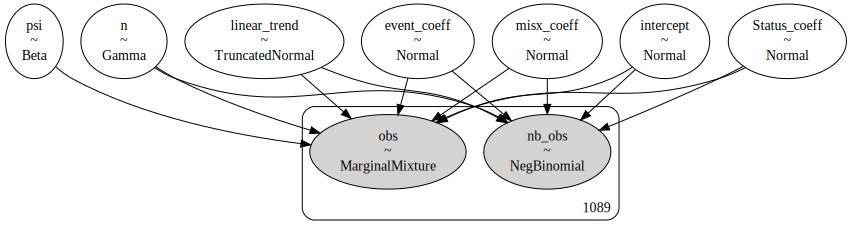

In [358]:
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, linear_trend, misx_coeff, Status_coeff, event_coeff, psi, n]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


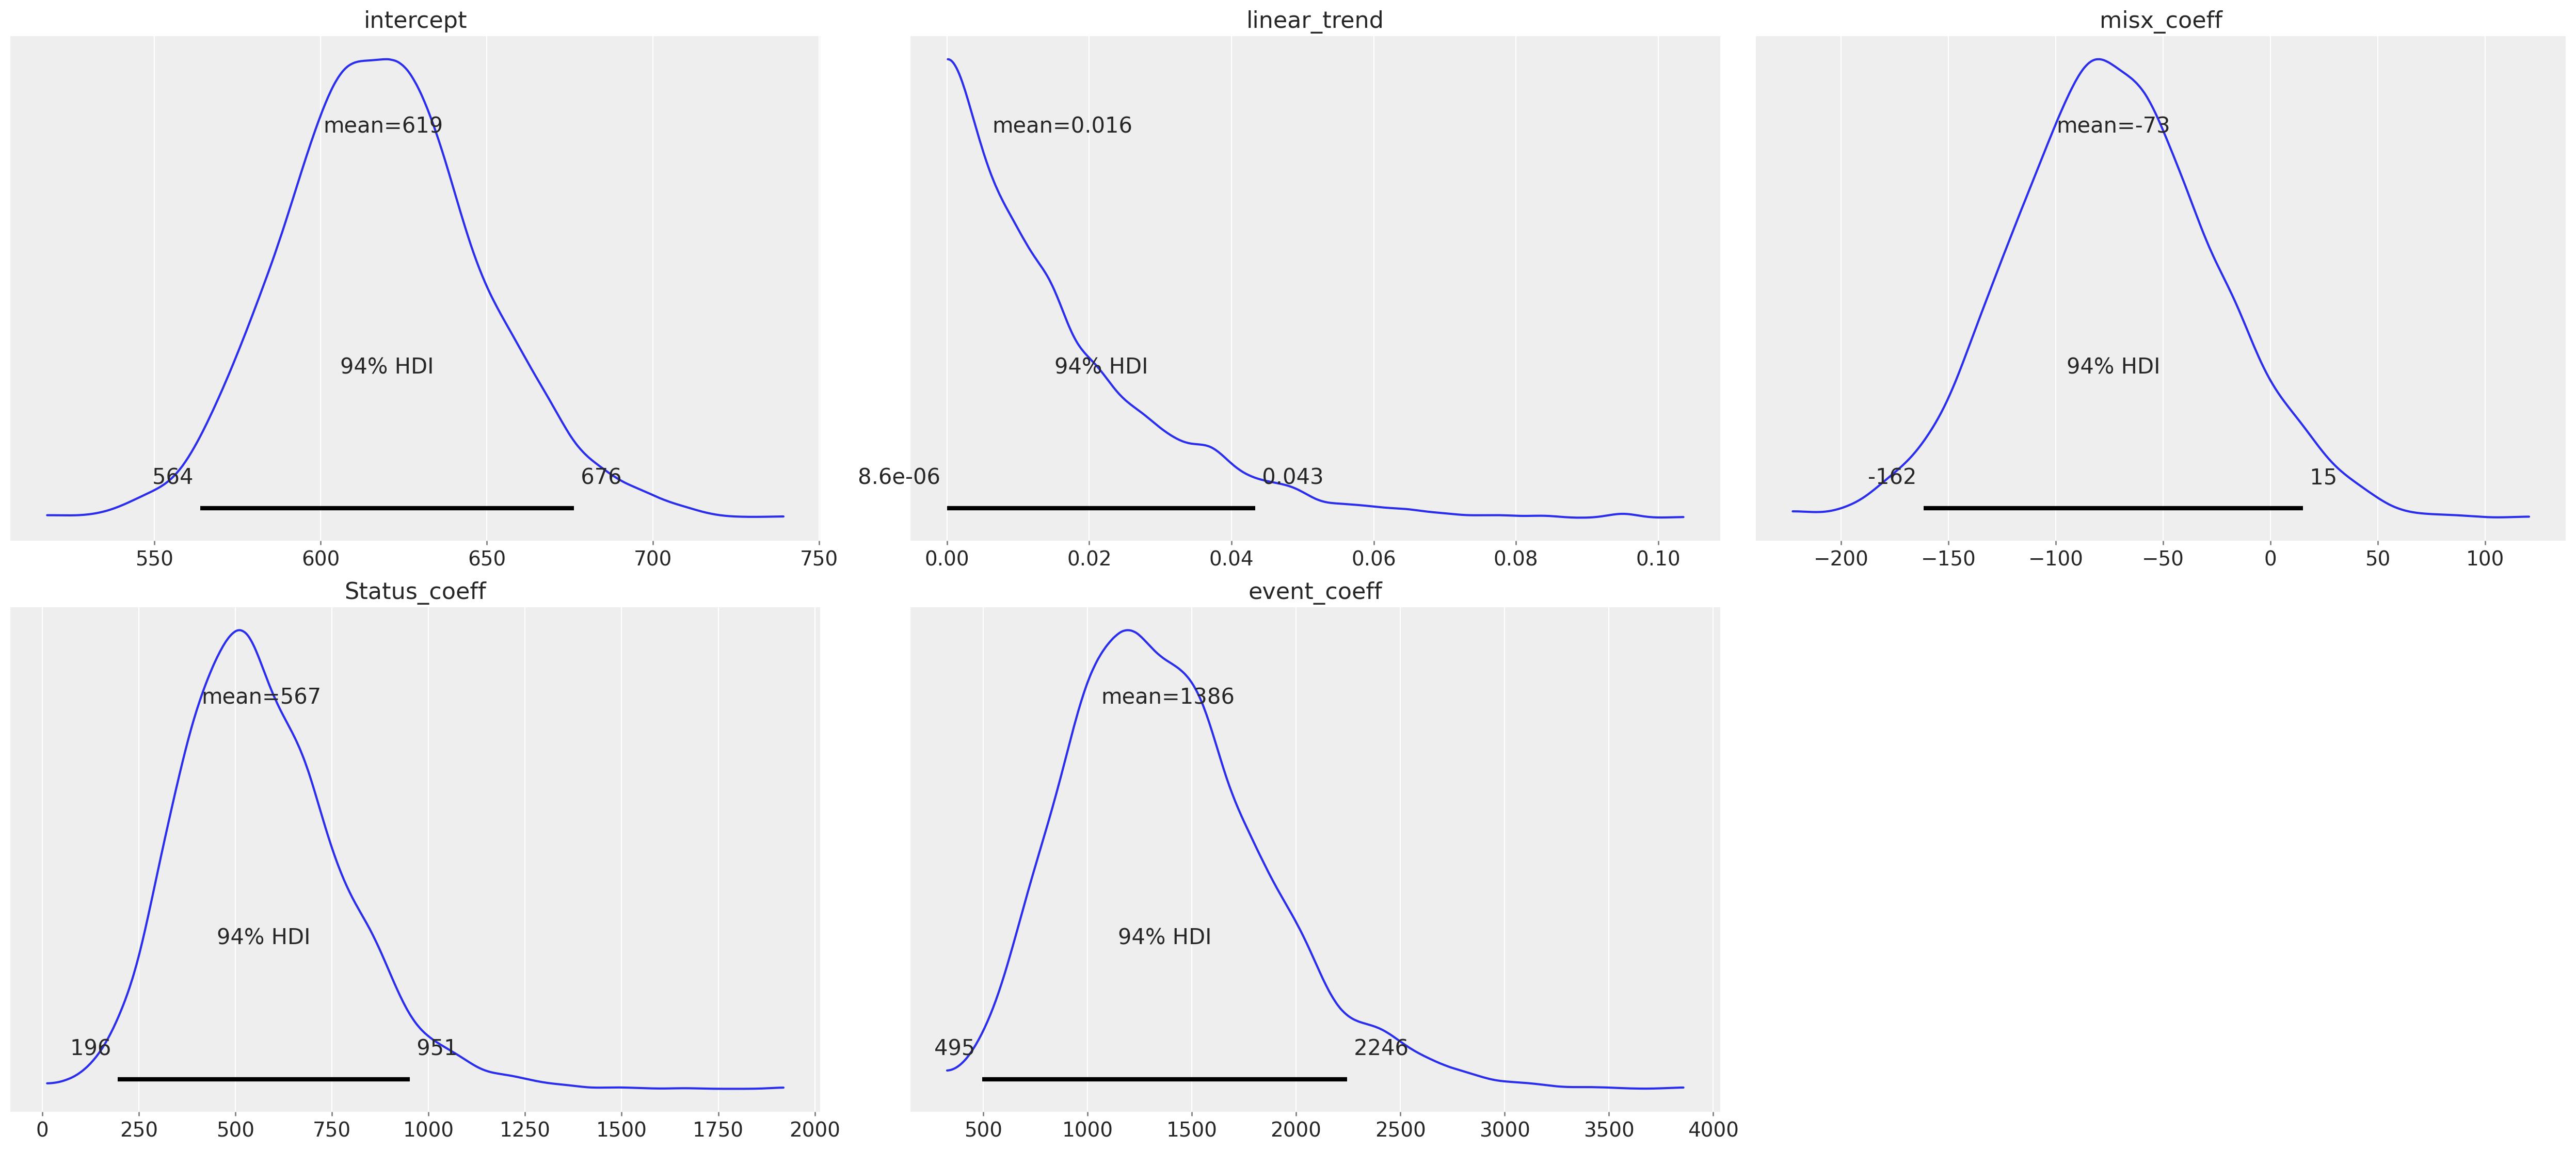

In [359]:
# Perform sampling
with model:
    trace = pm.sample(random_seed=RANDOM_SEED)

# Plot the results
pm.plot_posterior(trace, var_names=["intercept", "linear_trend", "misx_coeff", "Status_coeff", "event_coeff"])
plt.show()

Sampling: [nb_obs, obs]


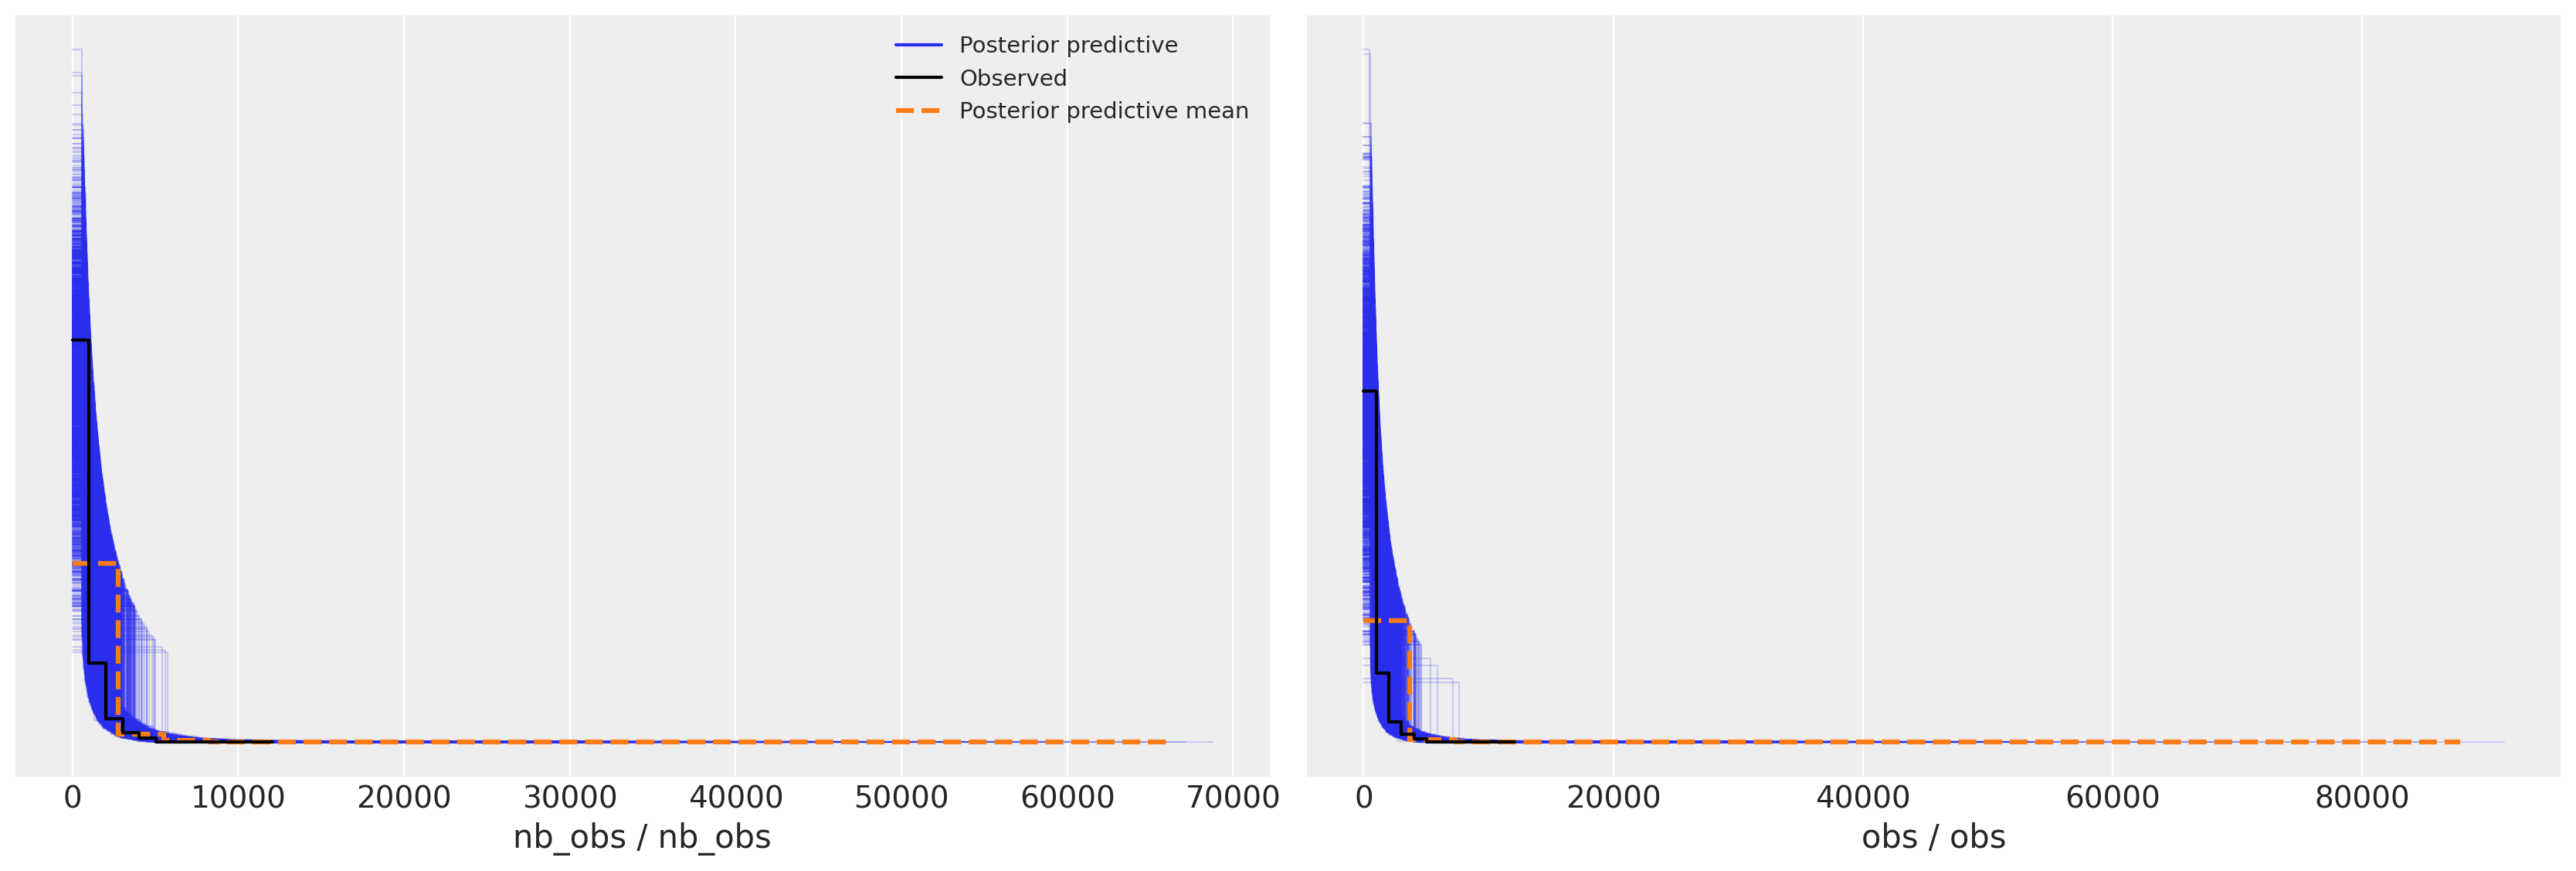

In [360]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(ppc)
plt.show()

In [361]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,618.806,30.024,563.717,676.289,0.527,0.374,3278.0,2774.0,1.0
misx_coeff,-73.155,47.146,-161.633,15.180,0.843,0.631,3113.0,2905.0,1.0
Status_coeff,567.042,210.069,195.571,951.299,3.974,3.179,3239.0,2098.0,1.0
event_coeff,1386.031,478.731,494.532,2245.866,8.892,7.241,3648.0,1976.0,1.0
linear_trend,0.016,0.015,0.000,0.043,0.000,0.000,2743.0,1890.0,1.0
psi,0.815,0.016,0.784,0.845,0.000,0.000,3240.0,2536.0,1.0
n,0.310,0.011,0.291,0.332,0.000,0.000,3171.0,2954.0,1.0


Sampling: [nb_obs, obs]


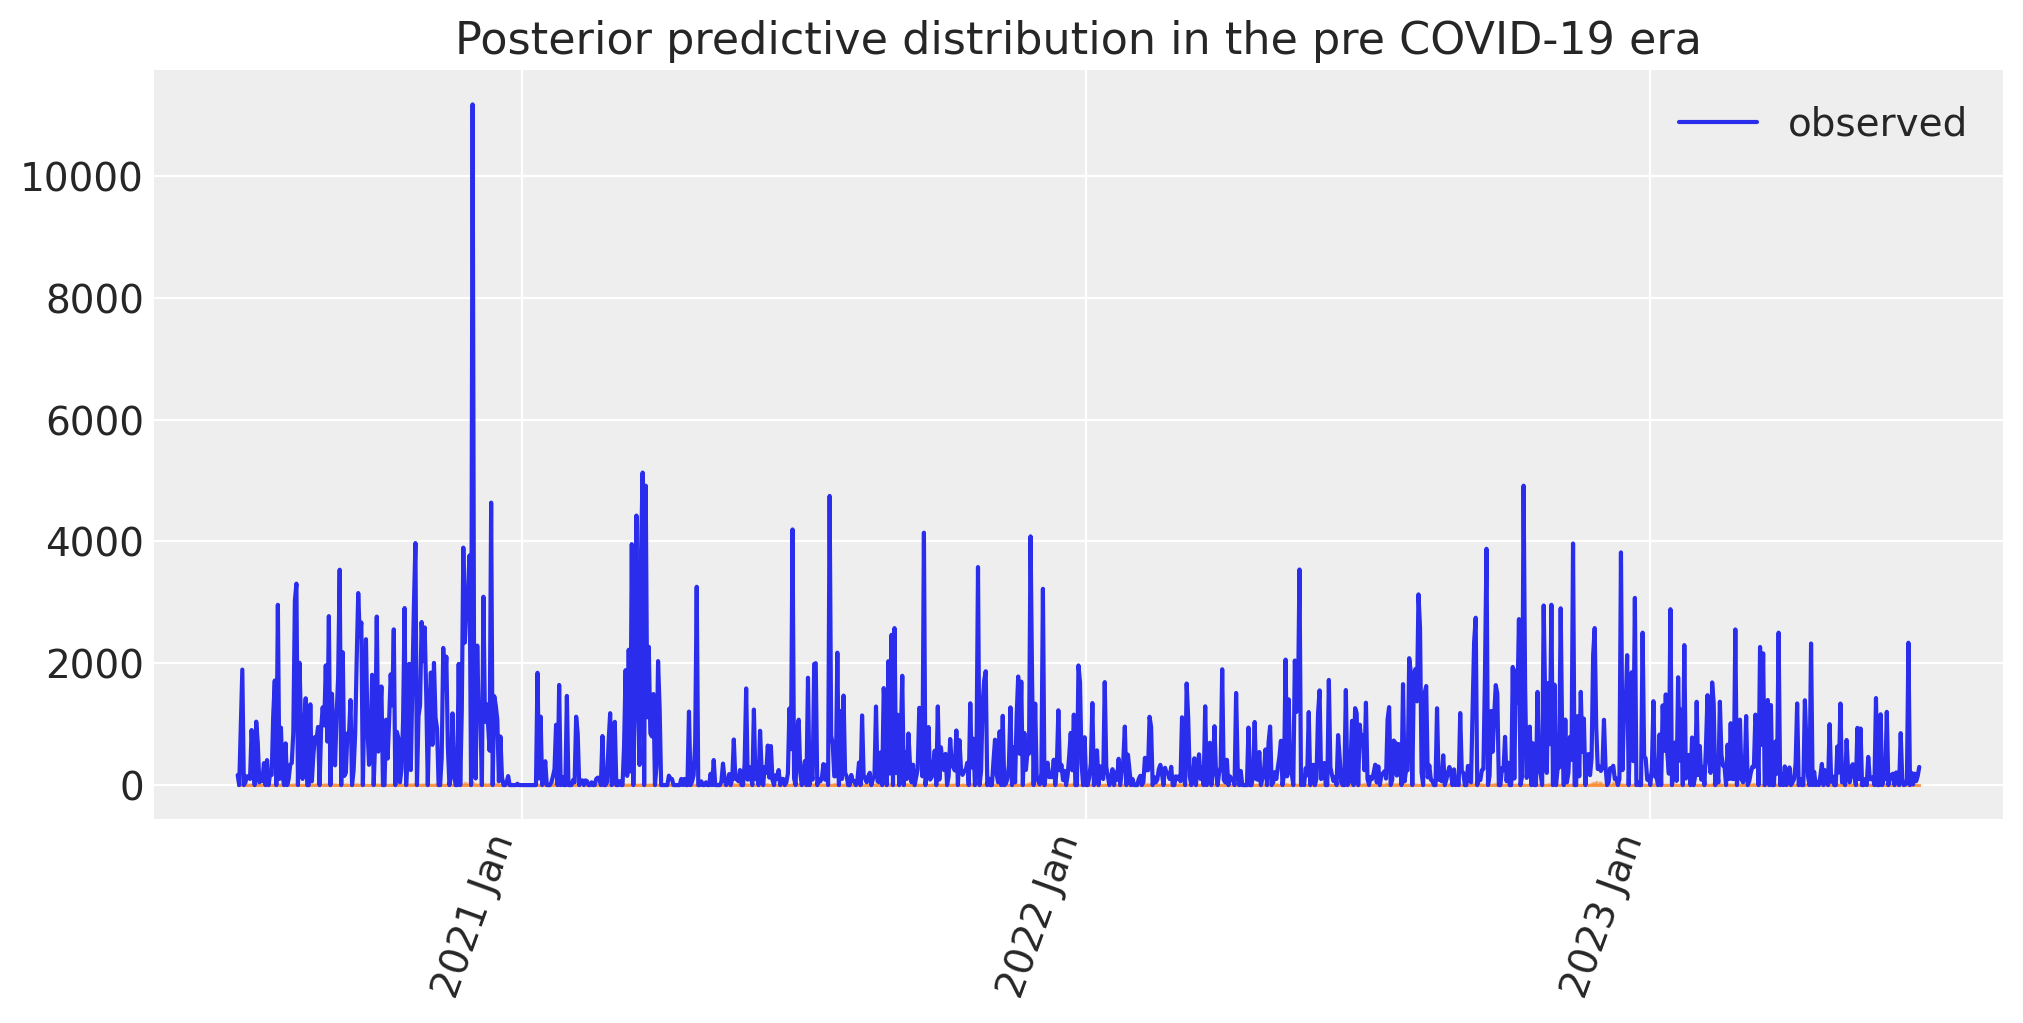

In [363]:
with model:
    trace.extend(pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED))


fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(storedata['Sales_Date'], trace.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(storedata['Sales_Date'], trace.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(storedata['Sales_Date'], storedata["Rslr_Sales_Amount"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend();